--- Data Loaded ---
(65188, 46)
------------------------------
CLNSIG_5class
Uncertain            65051
Pathogenic             100
Likely_Pathogenic       33
Benign                   2
Likely_Benign            2
Name: count, dtype: int64

 Duplicates Removed

 Missing values Removed

 Outliers Removed


/tmp/ipython-input-2481069625.py:53: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  coerced = pd.to_numeric(df[col], errors="ignore")



Top 6 features: ['CLNDISDBINCL', 'CLNDNINCL', 'CLNVC', 'DISTANCE', 'MOTIF_POS', 'HIGH_INF_POS']


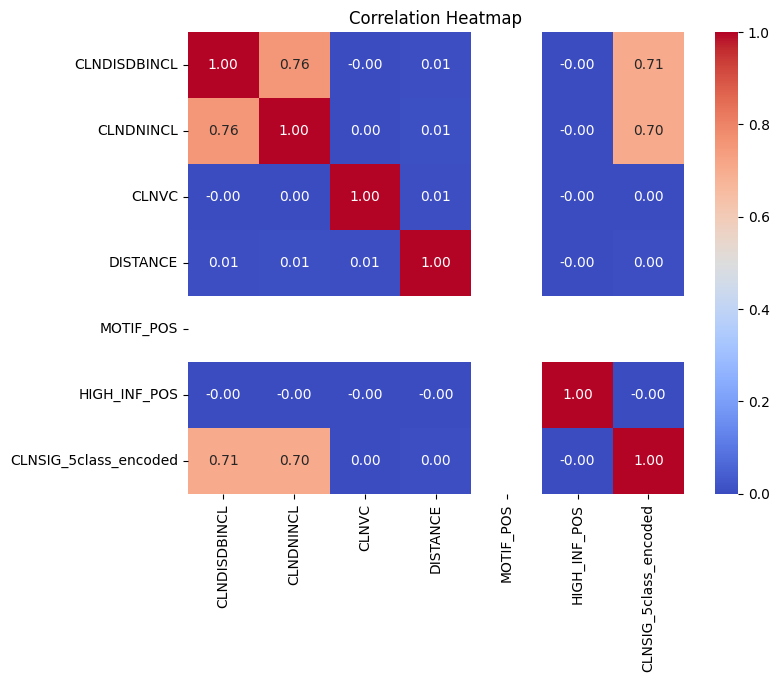

Before: CLNSIG_5class_encoded
4    65051
3      100
2       33
0        2
1        2
Name: count, dtype: int64
After: CLNSIG_5class_encoded
4    65051
2    65051
3    65051
0    65051
1    65051
Name: count, dtype: int64
Accuracy: 0.9945427433859587
                   precision    recall  f1-score   support

           Benign       1.00      1.00      1.00     13010
    Likely_Benign       1.00      1.00      1.00     13010
Likely_Pathogenic       0.98      1.00      0.99     13010
       Pathogenic       0.99      0.98      0.99     13011
        Uncertain       1.00      1.00      1.00     13010

         accuracy                           0.99     65051
        macro avg       0.99      0.99      0.99     65051
     weighted avg       0.99      0.99      0.99     65051



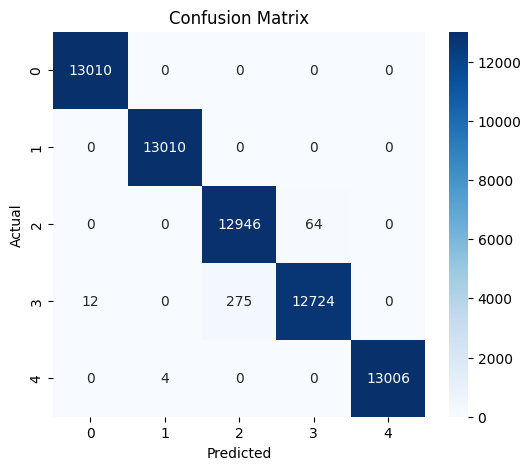

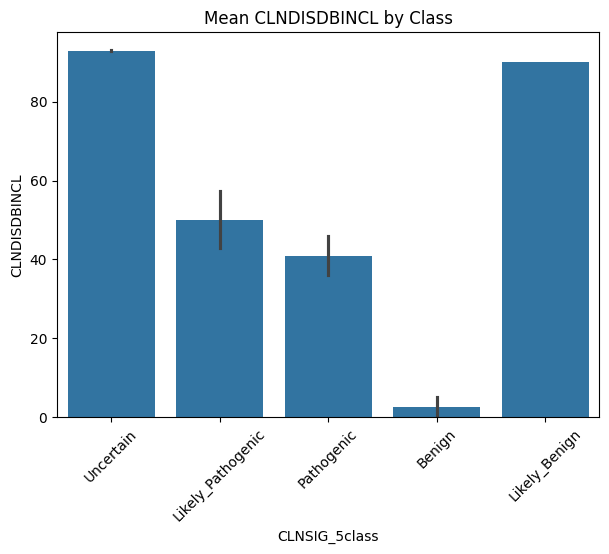

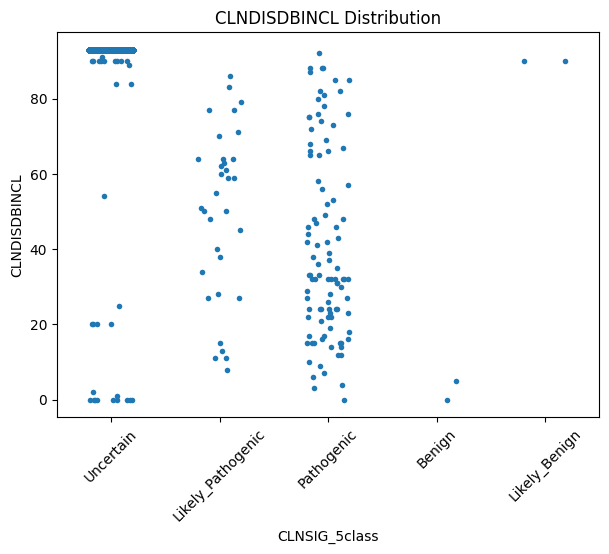

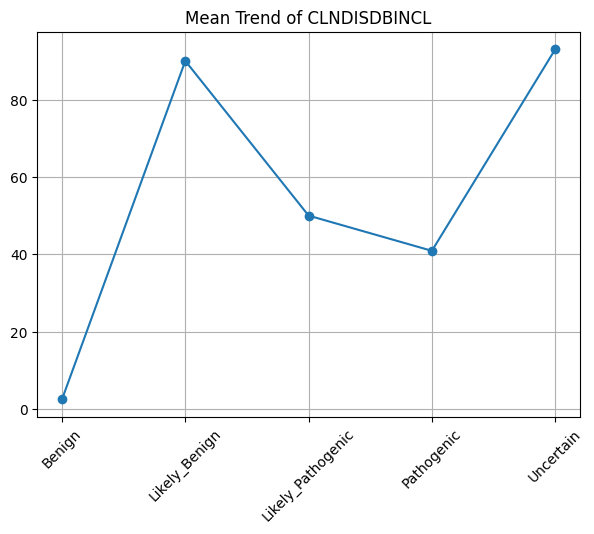

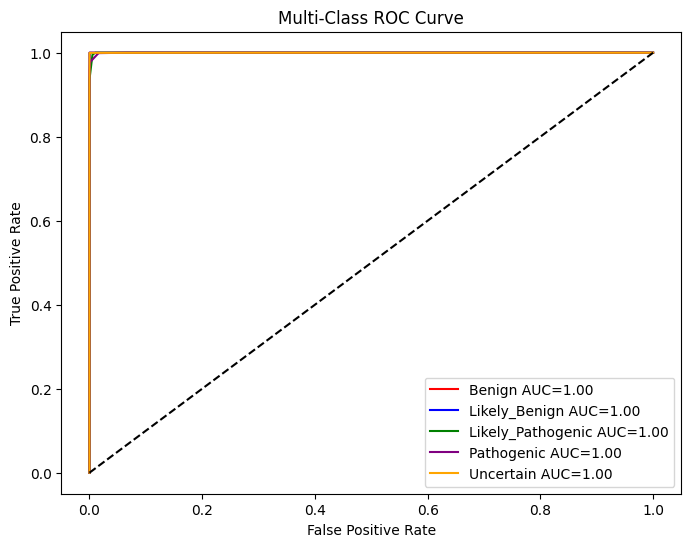

In [5]:
#  IMPORT LIBRARIES

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

#  LOAD DATA

df = pd.read_csv("/content/clinvar_conflicting.csv", low_memory=False)

print("--- Data Loaded ---")
print(df.shape)
print("-" * 30)

#  FIND TARGET COLUMN

target_candidates = [c for c in df.columns if c.strip().lower() == "clnsigincl"]
if not target_candidates:
    raise ValueError("CLNSIGINCL column not found.")
target_col = target_candidates[0]

#  CLEAN TARGET LABEL → 5 CLASSES

def classify_label(v):
    if pd.isna(v): return "Uncertain"
    s = str(v).lower()
    if "likely_benign" in s: return "Likely_Benign"
    if "likely_pathogenic" in s: return "Likely_Pathogenic"
    if "benign" in s and "likely" not in s: return "Benign"
    if "pathogenic" in s and "likely" not in s: return "Pathogenic"
    if "uncertain" in s or "risk_factor" in s or "other" in s:
        return "Uncertain"
    return "Uncertain"

df["CLNSIG_5class"] = df[target_col].apply(classify_label)

print(df["CLNSIG_5class"].value_counts())

#  PREPROCESSING

df = df.drop_duplicates().reset_index(drop=True)

print("\n Duplicates Removed")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Coerce object columns to numeric where possible
for col in df.select_dtypes(include=["object"]).columns:
    coerced = pd.to_numeric(df[col], errors="ignore")
    if coerced.dtype != "object":
        df[col + "_num"] = coerced
        numeric_cols.append(col + "_num")

# Handle missing numeric values (mean)
nan_numeric_cols = [c for c in numeric_cols if df[c].isna().any()]
df[nan_numeric_cols] = SimpleImputer(strategy="mean").fit_transform(df[nan_numeric_cols])

print("\n Missing values Removed")

# Outlier handling (IQR)
def handle_outliers(series):
    if not np.issubdtype(series.dtype, np.number): return series
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    if iqr == 0: return series
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return series.clip(low, high)

for col in numeric_cols:
    df[col] = handle_outliers(df[col])

print("\n Outliers Removed")

# Drop raw target col
df = df.drop(columns=[target_col])

# Encode categorical features
for col in df.select_dtypes(include=["object"]).columns:
    if col != "CLNSIG_5class":
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Encode target
le_target = LabelEncoder()
df["CLNSIG_5class_encoded"] = le_target.fit_transform(df["CLNSIG_5class"])

#  FEATURE SELECTION — TOP 6

X = df.drop(columns=["CLNSIG_5class", "CLNSIG_5class_encoded"])
y = df["CLNSIG_5class_encoded"]
X_num = X.select_dtypes(include=[np.number])

mi_scores = mutual_info_classif(X_num, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X_num.columns).sort_values(ascending=False)

top6 = mi_series.head(6).index.tolist()
print("\nTop 6 features:", top6)

#  CORRELATION HEATMAP (Before SMOTE)

plt.figure(figsize=(8, 6))
corr = df[top6 + ["CLNSIG_5class_encoded"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#  APPLY SMOTE

from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=1, random_state=42)
X_balanced, y_balanced = smote.fit_resample(df[top6], df["CLNSIG_5class_encoded"])

print("Before:", df["CLNSIG_5class_encoded"].value_counts())
print("After:", pd.Series(y_balanced).value_counts())

#  TRAIN-TEST SPLIT

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

#  RANDOM FOREST MODEL

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

#  CONFUSION MATRIX HEATMAP

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#  EXPLORATORY PLOTS (Bar, Scatter, Line)

target_feature = top6[0]

# Bar Plot
plt.figure(figsize=(7, 5))
sns.barplot(x=df["CLNSIG_5class"], y=df[target_feature], estimator="mean")
plt.title(f"Mean {target_feature} by Class")
plt.xticks(rotation=45)
plt.show()

# Scatter / Strip Plot
plt.figure(figsize=(7, 5))
sns.stripplot(x=df["CLNSIG_5class"], y=df[target_feature], jitter=0.2, size=4)
plt.title(f"{target_feature} Distribution")
plt.xticks(rotation=45)
plt.show()

# Line Graph (trend)
mean_trend = df.groupby("CLNSIG_5class_encoded")[target_feature].mean()
plt.figure(figsize=(7, 5))
plt.plot(mean_trend.index, mean_trend.values, marker="o")
plt.xticks(mean_trend.index, le_target.inverse_transform(mean_trend.index), rotation=45)
plt.title(f"Mean Trend of {target_feature}")
plt.grid(True)
plt.show()

#  ROC CURVE (MULTI-CLASS)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])
y_score = model.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8, 6))
colors = ["red", "blue", "green", "purple", "orange"]

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"{le_target.classes_[i]} AUC={roc_auc[i]:.2f}")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.show()